# DMS to YM Data Transformation

This notebook processes deep mutational scanning (DMS) data from Mason et al. (2021) into a format suitable for model training. It:

1. Loads raw MiXCR sequencing data from antigen-positive and antigen-negative selection pools
2. Calculates enrichment ratios between conditions for each antibody variant
3. Adds complete antibody sequence (scFv format) with mutated CDR-H3 regions
4. Transforms enrichment ratios to pseudo-affinity values for compatibility with model training

To reproduce, use the conda environment specified in `alphabind_analysis.yml`.

### Imports and path setup

---

In [1]:
from pathlib import Path

import Levenshtein
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
TRAST_DATA_PATH = Path("../data/trastuzumab_dms/")
MIXCR_DATA_PATH = TRAST_DATA_PATH / "mixcr_data"

### Data Loading and Preprocessing

---

The following 2 code cells process MiXCR immunological data from Mason et al. (2021). 
MiXCR is a tool for analyzing T-cell receptor and antibody repertoire sequencing data.

Source:
- Original code: https://github.com/dahjan/DMS_opt

Reference:
Mason, D. M., Friedensohn, S., Weber, C. R., Jordi, C., Wagner, B., Meng, S. M., 
Ehling, R. A., et al. (2021). Optimization of therapeutic antibodies by predicting 
antigen specificity from antibody sequence via deep learning. Nature Biomedical 
Engineering, 5(6), 600-612. DOI: 10.1038/s41551-021-00699-9

In [3]:
# negative data is concatenated sequencing data from Ab+ and Ag- pools (2 pools, 3 samples each)
# positive data is concatenated sequencing data from Ag+2 and Ag+3 pools (2 pools, 3 samples each)


def load_input_data(filenames, Ag_class):
    """
    Load the files specified in filenames.

    Parameters
    ---
    filenames: a list of names that specify the files to
        be loaded.

    Ag_class: classification of sequences from MiXCR txt file
               (i.e., antigen binder = 1, non-binder = 0)
    """

    # Combine the non-binding sequence data sets.
    # Non-binding data sets include Ab+ data and Ag-
    # sorted data for all 3 libraries
    l_data = []
    for file in filenames:
        l_data.append(mixcr_input(MIXCR_DATA_PATH / file, Ag_class, seq_len=15))
    mHER_H3 = pd.concat(l_data)

    # Drop duplicate sequences
    mHER_H3 = mHER_H3.drop_duplicates(subset="AASeq")

    # Remove 'CAR/CSR' motif and last two amino acids
    mHER_H3["AASeq"] = [x[3:-2] for x in mHER_H3["AASeq"]]

    # Shuffle sequences and reset index
    mHER_H3 = mHER_H3.sample(frac=1, random_state=1).reset_index(drop=True)

    return mHER_H3


def mixcr_input(file_name, Ag_class, seq_len):
    """
    Read in data from the MiXCR txt output file

    Parameters
    ---
    file_name: file name of the MiXCR txt file to read

    Ag_class: classification of sequences from MiXCR txt file
               (i.e., antigen binder = 1, non-binder = 0)

    seq_len: the length of sequences; other lengths will be
             removed.
    """

    # Read data and rename columns
    x = pd.read_table(file_name)
    x = x[["Clone count", "Clone fraction", "N. Seq. CDR3 ", "AA. Seq.CDR3 "]]
    x = x.rename(
        index=str,
        columns={
            "Clone count": "Count",
            "Clone fraction": "Fraction",
            "N. Seq. CDR3 ": "NucSeq",
            "AA. Seq.CDR3 ": "AASeq",
        },
    )
    #######
    # INCLUDE SAMPLE TOTAL COUNT
    x["Sample Count Total"] = x["Count"].sum()
    #######

    # Select length and drop duplicate sequences
    x = x[(x.AASeq.str.len() == seq_len) & (x.Count > 1)]
    x = x.drop_duplicates(subset="AASeq")

    # Remove stop codons and incomplete codon sequences (*, _)
    idx = [i for i, aa in enumerate(x["AASeq"]) if "*" not in aa]
    x = x.iloc[idx, :]
    idx = [i for i, aa in enumerate(x["AASeq"]) if "_" not in aa]
    x = x.iloc[idx, :]

    if Ag_class == 0:
        x["AgClass"] = 0
    if Ag_class == 1:
        x["AgClass"] = 1

    return x

In [4]:
# Load non-binding sequences
ab_neg_files = [
    "mHER_H3_1_Ab.txt",
    "mHER_H3_1_AgN.txt",
    "mHER_H3_2_Ab.txt",
    "mHER_H3_2_AgN.txt",
    "mHER_H3_3_Ab.txt",
    "mHER_H3_3_AgN.txt",
]
mHER_H3_AgNeg = load_input_data(ab_neg_files, Ag_class=0)

# Load binding sequences
ab_pos_files = [
    "mHER_H3_1_2Ag647.txt",
    "mHER_H3_1_2Ag488.txt",
    "mHER_H3_2_2Ag647.txt",
    "mHER_H3_2_2Ag488.txt",
    "mHER_H3_3_2Ag647.txt",
    "mHER_H3_3_2Ag488.txt",
]
mHER_H3_AgPos = load_input_data(ab_pos_files, Ag_class=1)

# Save those files
mHER_H3_AgNeg.to_csv(MIXCR_DATA_PATH / "mHER_H3_AgNeg.csv")
mHER_H3_AgPos.to_csv(MIXCR_DATA_PATH / "mHER_H3_AgPos.csv")

In [5]:
# examine counts and duplicates
df_neg = pd.read_csv(MIXCR_DATA_PATH / "mHER_H3_AgNeg.csv", index_col=0)
df_pos = pd.read_csv(MIXCR_DATA_PATH / "mHER_H3_AgPos.csv", index_col=0)

print("# neg rows:", df_neg.shape[0])
print("# pos rows:", df_pos.shape[0])
print("")
print("# unique neg nucleotide seqs:", df_neg["NucSeq"].unique().size)
print("# unique pos nucleotide seqs:", df_pos["NucSeq"].unique().size)
print("")
print("# unique neg aa seqs:", df_neg["AASeq"].unique().size)
print("# unique pos aa seqs:", df_pos["AASeq"].unique().size)
print("")
print(
    "# common nucleotide seqs:",
    df_neg.drop_duplicates("NucSeq")
    .merge(df_pos.drop_duplicates("NucSeq"), on="NucSeq")
    .shape[0],
)
print(
    "# common aa seqs:",
    df_neg.drop_duplicates("AASeq")
    .merge(df_pos.drop_duplicates("AASeq"), on="AASeq")
    .shape[0],
)

# neg rows: 27539
# pos rows: 11300

# unique neg nucleotide seqs: 27539
# unique pos nucleotide seqs: 11300

# unique neg aa seqs: 27456
# unique pos aa seqs: 11277

# common nucleotide seqs: 2339
# common aa seqs: 2342


In [6]:
df_pos["Fraction"].describe()

count    11300.000000
mean         0.000266
std          0.000544
min          0.000003
25%          0.000028
50%          0.000093
75%          0.000276
max          0.015084
Name: Fraction, dtype: float64

In [7]:
df_neg["Fraction"].describe()

count    2.753900e+04
mean     2.932879e-05
std      5.020010e-05
min      8.536841e-07
25%      3.942367e-06
50%      1.195158e-05
75%      3.366208e-05
max      8.564791e-04
Name: Fraction, dtype: float64

In [8]:
# all unique aa seqs measured
27456 + 11277 - 2342

36391

### Compute enrichment ratios

---

In [9]:
def adjust_fraction(df):
    """To account for AASeqs that appeared in more than one sample, compute an adjusted fraction.
    Take the first NucSeq, since it doesn't matter for our purposes.

    Eg, if sequence X appeared in samples 1 and 2, then adj_fraction = (count_1 + count_2) / (total_1 + total_2)
    """

    def _apply_adj_fraction(gdf):
        d = {}
        d["Count"] = gdf["Count"].sum()
        d["NucSeq"] = gdf["NucSeq"].values[0]
        d["Sample Count Total"] = gdf["Sample Count Total"].sum()
        d["Adj Fraction"] = gdf["Count"].sum() / gdf["Sample Count Total"].sum()
        d["AgClass"] = gdf["AgClass"].values[0]
        return pd.Series(
            d,
            index=["Count", "NucSeq", "Sample Count Total", "Adj Fraction", "AgClass"],
        )

    return df.groupby("AASeq", as_index=False).apply(_apply_adj_fraction)

In [10]:
df_pos_adj = adjust_fraction(df_pos)
df_neg_adj = adjust_fraction(df_neg)

/var/folders/rj/d_7gx_5938787qyfz5wbskqw0000gq/T/ipykernel_86333/2368570392.py:20: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby("AASeq", as_index=False).apply(_apply_adj_fraction)
/var/folders/rj/d_7gx_5938787qyfz5wbskqw0000gq/T/ipykernel_86333/2368570392.py:20: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby("AASeq", as_index=False).apply(_apply_adj_fraction)


In [11]:
# calculate pooled totals in each group
pos_pooled_total = df_pos["Sample Count Total"].unique().sum()
neg_pooled_total = df_neg["Sample Count Total"].unique().sum()


df_pos_adj = df_pos_adj.rename(
    columns={
        "Count": "Positive Count",
        "Sample Count Total": "Positive Sample Count Total",
        "Adj Fraction": "Positive Adj Fraction",
    }
).drop(columns=["AgClass", "NucSeq"])
df_neg_adj = df_neg_adj.rename(
    columns={
        "Count": "Negative Count",
        "Sample Count Total": "Negative Sample Count Total",
        "Adj Fraction": "Negative Adj Fraction",
    }
).drop(columns=["AgClass", "NucSeq"])


# merge positive and negative data
df_pos_neg = df_pos_adj.merge(df_neg_adj, how="outer", on="AASeq")
df_pos_neg["Positive Read"] = ~df_pos_neg["Positive Count"].isna()
df_pos_neg["Negative Read"] = ~df_pos_neg["Negative Count"].isna()
# infill missing count data with pseudocounts
df_pos_neg["Positive Count"] = df_pos_neg["Positive Count"].fillna(1.0)
df_pos_neg["Negative Count"] = df_pos_neg["Negative Count"].fillna(1.0)
# infill missing count total data with pooled totals
df_pos_neg["Positive Sample Count Total"] = df_pos_neg[
    "Positive Sample Count Total"
].fillna(pos_pooled_total)
df_pos_neg["Negative Sample Count Total"] = df_pos_neg[
    "Negative Sample Count Total"
].fillna(neg_pooled_total)
# infill missing fraction data with pseudocounts / pooled totals
df_pos_neg["Positive Adj Fraction"] = df_pos_neg["Positive Adj Fraction"].fillna(
    df_pos_neg["Positive Count"] / df_pos_neg["Positive Sample Count Total"]
)
df_pos_neg["Negative Adj Fraction"] = df_pos_neg["Negative Adj Fraction"].fillna(
    df_pos_neg["Negative Count"] / df_pos_neg["Negative Sample Count Total"]
)
# compute enrichment ratio between positive and negative clonotype fractions
df_pos_neg["Enrichment Ratio"] = np.log(
    df_pos_neg["Positive Adj Fraction"] / df_pos_neg["Negative Adj Fraction"]
)
df_pos_neg

,AASeq,Positive Count,Positive Sample Count Total,Positive Adj Fraction,Negative Count,Negative Sample Count Total,Negative Adj Fraction,Positive Read,Negative Read,Enrichment Ratio
0,CAGHGLYVFL,2.0,506914.0,3.945442e-06,1.0,8040511.0,1.243702e-07,True,False,3.457054
1,CAGNRLFVFW,2.0,647932.0,3.086744e-06,1.0,8040511.0,1.243702e-07,True,False,3.211609
2,CAGVGFFVFT,1.0,3617146.0,2.764611e-07,47.0,2198319.0,2.137997e-05,False,True,-4.348140
3,CAKYALYPLL,1.0,3617146.0,2.764611e-07,44.0,2198319.0,2.001529e-05,False,True,-4.282182
4,CANHGFFVHV,1.0,3617146.0,2.764611e-07,2.0,2198319.0,9.097861e-07,False,True,-1.191140
...,...,...,...,...,...,...,...,...,...,...
36386,YYVRHPYVYK,1.0,3617146.0,2.764611e-07,117.0,843691.0,1.386764e-04,False,True,-6.217828
36387,YYVSDYYLNG,1.0,3617146.0,2.764611e-07,25.0,2342787.0,1.067105e-05,False,True,-3.653220
36388,YYVSGYFLNL,1.0,3617146.0,2.764611e-07,4.0,2342787.0,1.707368e-06,False,True,-1.820638
36389,YYVVDPYTFK,1.0,3617146.0,2.764611e-07,34.0,2342787.0,1.451263e-05,False,True,-3.960705


In [12]:
df_pos_neg.sort_values("Enrichment Ratio")

,AASeq,Positive Count,Positive Sample Count Total,Positive Adj Fraction,Negative Count,Negative Sample Count Total,Negative Adj Fraction,Positive Read,Negative Read,Enrichment Ratio
28809,YDGSSFYLFI,1.0,3617146.0,2.764611e-07,869.0,1014619.0,8.564791e-04,False,True,-8.038515
2435,FGHSGFYEFD,1.0,3617146.0,2.764611e-07,382.0,535302.0,7.136159e-04,False,True,-7.856030
23480,WRRLSMYQIK,1.0,3617146.0,2.764611e-07,691.0,1014619.0,6.810438e-04,False,True,-7.809312
22419,WRACSFYKID,1.0,3617146.0,2.764611e-07,355.0,535302.0,6.631770e-04,False,True,-7.782727
19375,WLVGSMYPFT,1.0,3617146.0,2.764611e-07,346.0,535302.0,6.463641e-04,False,True,-7.757048
...,...,...,...,...,...,...,...,...,...,...
29767,YGEPSFFVFL,3439.0,796659.0,4.316778e-03,1.0,8040511.0,1.243702e-07,True,False,10.454757
14673,WGNNSLYAFD,2195.0,506914.0,4.330123e-03,1.0,8040511.0,1.243702e-07,True,False,10.457844
32751,YMHVGFYAFC,2436.0,558127.0,4.364598e-03,1.0,8040511.0,1.243702e-07,True,False,10.465774
33145,YNNGGLYVYR,2588.0,558127.0,4.636937e-03,1.0,8040511.0,1.243702e-07,True,False,10.526302


Text(0.5, 0, 'Enrichment Ratio')

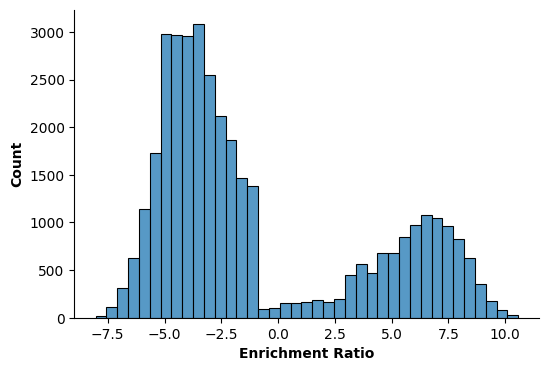

In [13]:
fig, ax = plt.subplots(1, figsize=(6, 4))
sns.histplot(data=df_pos_neg, x="Enrichment Ratio")
sns.despine()
ax.set_ylabel("Count", fontweight="bold")
ax.set_xlabel("Enrichment Ratio", fontweight="bold")

### Transform into AlphaBind format

---

Add the rest of the sequence, linear transformation of enrichment ratios to pseudo-affinities

In [14]:
# DMS data only includes CDRH3 sequence; add the rest of the sequence as an HL scFv version of Trastuzumab
# scFv versions of the sequences were those used to fine-tune then validate in our experiment
upstream_seq = "EVQLVESGGGLVQPGGSLRLSCAASGFNIKDTYIHWVRQAPGKGLEWVARIYPTNGYTRYADSVKGRFTISADTSKNTAYLQMNSLRAEDTAVYYCSR"
downstream_seq = "YWGQGTLVTVSSGGGGSGGGGSGGGGSDIQMTQSPSSLSASVGDRVTITCRASQDVNTAVAWYQQKPGKAPKLLIYSASFLYSGVPSRFSGSRSGTDFTLTISSLQPEDFATYYCQQHYTTPPTFGQGTKVEIKR"
her2_seq = "ACHQLCARGHCSGPGPTQCVNCSQFLRGQECVEECRVLQGLPREYVNARHCLPCHPECQPQNGSVTCFGPEADQCVACAHYKDPPFCVARCPSGVKPDLSYMPIWKFPDEEGACQPSPIN"
parental_full_seq = "EVQLVESGGGLVQPGGSLRLSCAASGFNIKDTYIHWVRQAPGKGLEWVARIYPTNGYTRYADSVKGRFTISADTSKNTAYLQMNSLRAEDTAVYYCSRWGGDGFYAMDYWGQGTLVTVSSGGGGSGGGGSGGGGSDIQMTQSPSSLSASVGDRVTITCRASQDVNTAVAWYQQKPGKAPKLLIYSASFLYSGVPSRFSGSRSGTDFTLTISSLQPEDFATYYCQQHYTTPPTFGQGTKVEIKR"

In [15]:
df_pos_neg_seq = df_pos_neg.copy()
df_pos_neg_seq["Full Seq"] = df_pos_neg_seq["AASeq"].apply(
    lambda s: upstream_seq + s + downstream_seq
)
df_pos_neg_seq["Target Seq"] = her2_seq
df_pos_neg_seq["Edit Distance"] = df_pos_neg_seq["Full Seq"].apply(
    lambda s: Levenshtein.distance(parental_full_seq, s)
)

df_pos_neg_seq

,AASeq,Positive Count,Positive Sample Count Total,Positive Adj Fraction,Negative Count,Negative Sample Count Total,Negative Adj Fraction,Positive Read,Negative Read,Enrichment Ratio,Full Seq,Target Seq,Edit Distance
0,CAGHGLYVFL,2.0,506914.0,3.945442e-06,1.0,8040511.0,1.243702e-07,True,False,3.457054,EVQLVESGGGLVQPGGSLRLSCAASGFNIKDTYIHWVRQAPGKGLE...,ACHQLCARGHCSGPGPTQCVNCSQFLRGQECVEECRVLQGLPREYV...,7
1,CAGNRLFVFW,2.0,647932.0,3.086744e-06,1.0,8040511.0,1.243702e-07,True,False,3.211609,EVQLVESGGGLVQPGGSLRLSCAASGFNIKDTYIHWVRQAPGKGLE...,ACHQLCARGHCSGPGPTQCVNCSQFLRGQECVEECRVLQGLPREYV...,9
2,CAGVGFFVFT,1.0,3617146.0,2.764611e-07,47.0,2198319.0,2.137997e-05,False,True,-4.348140,EVQLVESGGGLVQPGGSLRLSCAASGFNIKDTYIHWVRQAPGKGLE...,ACHQLCARGHCSGPGPTQCVNCSQFLRGQECVEECRVLQGLPREYV...,7
3,CAKYALYPLL,1.0,3617146.0,2.764611e-07,44.0,2198319.0,2.001529e-05,False,True,-4.282182,EVQLVESGGGLVQPGGSLRLSCAASGFNIKDTYIHWVRQAPGKGLE...,ACHQLCARGHCSGPGPTQCVNCSQFLRGQECVEECRVLQGLPREYV...,9
4,CANHGFFVHV,1.0,3617146.0,2.764611e-07,2.0,2198319.0,9.097861e-07,False,True,-1.191140,EVQLVESGGGLVQPGGSLRLSCAASGFNIKDTYIHWVRQAPGKGLE...,ACHQLCARGHCSGPGPTQCVNCSQFLRGQECVEECRVLQGLPREYV...,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...
36386,YYVRHPYVYK,1.0,3617146.0,2.764611e-07,117.0,843691.0,1.386764e-04,False,True,-6.217828,EVQLVESGGGLVQPGGSLRLSCAASGFNIKDTYIHWVRQAPGKGLE...,ACHQLCARGHCSGPGPTQCVNCSQFLRGQECVEECRVLQGLPREYV...,9
36387,YYVSDYYLNG,1.0,3617146.0,2.764611e-07,25.0,2342787.0,1.067105e-05,False,True,-3.653220,EVQLVESGGGLVQPGGSLRLSCAASGFNIKDTYIHWVRQAPGKGLE...,ACHQLCARGHCSGPGPTQCVNCSQFLRGQECVEECRVLQGLPREYV...,9
36388,YYVSGYFLNL,1.0,3617146.0,2.764611e-07,4.0,2342787.0,1.707368e-06,False,True,-1.820638,EVQLVESGGGLVQPGGSLRLSCAASGFNIKDTYIHWVRQAPGKGLE...,ACHQLCARGHCSGPGPTQCVNCSQFLRGQECVEECRVLQGLPREYV...,9
36389,YYVVDPYTFK,1.0,3617146.0,2.764611e-07,34.0,2342787.0,1.451263e-05,False,True,-3.960705,EVQLVESGGGLVQPGGSLRLSCAASGFNIKDTYIHWVRQAPGKGLE...,ACHQLCARGHCSGPGPTQCVNCSQFLRGQECVEECRVLQGLPREYV...,9


In [16]:
df_kd = df_pos_neg_seq.copy()[
    ["Full Seq", "Target Seq", "Enrichment Ratio", "Edit Distance"]
].rename(
    columns={
        "Full Seq": "mata_sequence",
        "Target Seq": "matalpha_sequence",
        "Edit Distance": "edit_distance",
    }
)
df_kd["mata_description"] = [
    f"trastuzumab_candidate_{i}" for i in range(df_kd.shape[0])
]
df_kd["matalpha_description"] = "HER2_AP"

# transform enrichment ratios to pseudo-affinity
# standard scale enrichment ratios, then add 2 to give them a distribution that looks like AlphaSeq affinity in log10 KD nM
df_kd["Kd"] = (
    (df_kd["Enrichment Ratio"] - df_kd["Enrichment Ratio"].mean())
    / df_kd["Enrichment Ratio"].std()
) + 2.0
df_kd = df_kd[
    [
        "mata_description",
        "mata_sequence",
        "matalpha_description",
        "matalpha_sequence",
        "Kd",
        "edit_distance",
    ]
]

df_kd.to_csv(TRAST_DATA_PATH / "Mason_Trastuzumab_DMS_to_YM_format.csv", index=False)

df_kd

,mata_description,mata_sequence,matalpha_description,matalpha_sequence,Kd,edit_distance
0,trastuzumab_candidate_0,EVQLVESGGGLVQPGGSLRLSCAASGFNIKDTYIHWVRQAPGKGLE...,HER2_AP,ACHQLCARGHCSGPGPTQCVNCSQFLRGQECVEECRVLQGLPREYV...,2.921248,7
1,trastuzumab_candidate_1,EVQLVESGGGLVQPGGSLRLSCAASGFNIKDTYIHWVRQAPGKGLE...,HER2_AP,ACHQLCARGHCSGPGPTQCVNCSQFLRGQECVEECRVLQGLPREYV...,2.868780,9
2,trastuzumab_candidate_2,EVQLVESGGGLVQPGGSLRLSCAASGFNIKDTYIHWVRQAPGKGLE...,HER2_AP,ACHQLCARGHCSGPGPTQCVNCSQFLRGQECVEECRVLQGLPREYV...,1.252761,7
3,trastuzumab_candidate_3,EVQLVESGGGLVQPGGSLRLSCAASGFNIKDTYIHWVRQAPGKGLE...,HER2_AP,ACHQLCARGHCSGPGPTQCVNCSQFLRGQECVEECRVLQGLPREYV...,1.266861,9
4,trastuzumab_candidate_4,EVQLVESGGGLVQPGGSLRLSCAASGFNIKDTYIHWVRQAPGKGLE...,HER2_AP,ACHQLCARGHCSGPGPTQCVNCSQFLRGQECVEECRVLQGLPREYV...,1.927621,8
...,...,...,...,...,...,...
36386,trastuzumab_candidate_36386,EVQLVESGGGLVQPGGSLRLSCAASGFNIKDTYIHWVRQAPGKGLE...,HER2_AP,ACHQLCARGHCSGPGPTQCVNCSQFLRGQECVEECRVLQGLPREYV...,0.853085,9
36387,trastuzumab_candidate_36387,EVQLVESGGGLVQPGGSLRLSCAASGFNIKDTYIHWVRQAPGKGLE...,HER2_AP,ACHQLCARGHCSGPGPTQCVNCSQFLRGQECVEECRVLQGLPREYV...,1.401312,9
36388,trastuzumab_candidate_36388,EVQLVESGGGLVQPGGSLRLSCAASGFNIKDTYIHWVRQAPGKGLE...,HER2_AP,ACHQLCARGHCSGPGPTQCVNCSQFLRGQECVEECRVLQGLPREYV...,1.793056,9
36389,trastuzumab_candidate_36389,EVQLVESGGGLVQPGGSLRLSCAASGFNIKDTYIHWVRQAPGKGLE...,HER2_AP,ACHQLCARGHCSGPGPTQCVNCSQFLRGQECVEECRVLQGLPREYV...,1.335582,9


<Axes: xlabel='Kd', ylabel='Count'>

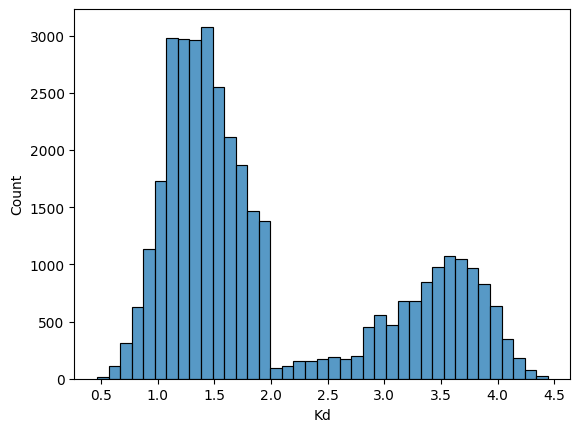

In [17]:
sns.histplot(data=df_kd, x="Kd")